In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from matplotlib import pyplot as plt
from data.dataloader import synthetic_dataset
from torch.utils.data import DataLoader
from model import Model

get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')



In [4]:
def set_random_seed(seed):
    torch.random.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic=True

set_random_seed(1)

In [5]:
device = 'cuda:0'

# Some settings related to the synthetic data
nr_classes = 3         # The number of classes in the data
nr_channels = 2        # The number of channels of the data
window_length = 3000   # The number of samples per labelled window
k = 1                  # The number of mini-windows to select per window
nr_iters = 500         # The number of iterations to train the model

settings = {
'hypernet_settings':{'input_dim':[nr_channels,window_length],  
                    'output_channels':[8,16,32,64], 
                    'kernel_sizes':[15,9,5,3], 
                    'poolings':[5,5,3],  #The last layer has no pooling, so no pooling factor needs to be set.
                    'gumbel_softmax_temperature':{'start':10.0, 'end':0.5, 'nr_iters':nr_iters//2}, # nr_iters is the nr of iterations in which the temperature decays from start to end value.
                    'k': k, 
                    'mini_window_temporal_reduction_factor': 6, #the factor with which mini-windows are smaller in the temporal dimension that the full windows of length window_length
                    }, 
'encoder_settings':{
                    'output_channels':[8,16,32,64],
                    'kernel_sizes':[15,9,5,3], 
                    'poolings':[5,5,3]}, #The last layer is a adaptive average pooling, so no pooling factor needs to be set.
'sampling_type': 'active', #  Choose from: {'active', 'random'}
'nr_classes':nr_classes
}


### Train a model

Iteration 1/500, Loss: 1.0962542295455933 - Val. loss: 1.0955417156219482
Stored a new best model at iteration 1.
Iteration 2/500, Loss: 1.0834956169128418 - Val. loss: 1.0168697834014893
Stored a new best model at iteration 2.
Iteration 3/500, Loss: 0.7685622572898865 - Val. loss: 1.3401544094085693
Iteration 4/500, Loss: 0.5610847473144531 - Val. loss: 4.224589824676514
Iteration 5/500, Loss: 0.3202623724937439 - Val. loss: 5.894551753997803
Iteration 6/500, Loss: 0.2375037521123886 - Val. loss: 7.063493728637695
Iteration 7/500, Loss: 0.21829800307750702 - Val. loss: 8.034384727478027
Iteration 8/500, Loss: 0.20613127946853638 - Val. loss: 8.713430404663086
Iteration 9/500, Loss: 0.1984342783689499 - Val. loss: 8.447510719299316
Iteration 10/500, Loss: 0.19137682020664215 - Val. loss: 8.633234977722168
Iteration 11/500, Loss: 0.18392467498779297 - Val. loss: 8.9021635055542
Iteration 12/500, Loss: 0.1843423694372177 - Val. loss: 8.132853507995605
Iteration 13/500, Loss: 0.1800074428

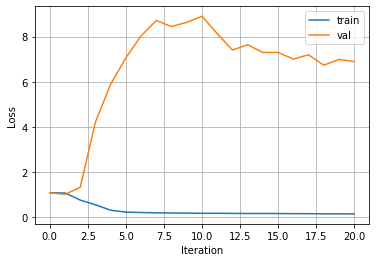

Iteration 22/500, Loss: 0.1538550704717636 - Val. loss: 6.310749530792236
Iteration 23/500, Loss: 0.1492190808057785 - Val. loss: 6.282815456390381
Iteration 24/500, Loss: 0.1453395038843155 - Val. loss: 6.277095317840576
Iteration 25/500, Loss: 0.14255291223526 - Val. loss: 5.882094860076904
Iteration 26/500, Loss: 0.13951319456100464 - Val. loss: 6.407725811004639
Iteration 27/500, Loss: 0.1348717212677002 - Val. loss: 6.344911098480225
Iteration 28/500, Loss: 0.134550079703331 - Val. loss: 6.2285003662109375
Iteration 29/500, Loss: 0.1315843164920807 - Val. loss: 5.82011079788208
Iteration 30/500, Loss: 0.12728849053382874 - Val. loss: 5.673030376434326
Iteration 31/500, Loss: 0.12577663362026215 - Val. loss: 5.472508430480957
Iteration 32/500, Loss: 0.12587778270244598 - Val. loss: 5.474877834320068
Iteration 33/500, Loss: 0.11957341432571411 - Val. loss: 5.395678997039795
Iteration 34/500, Loss: 0.12124235928058624 - Val. loss: 5.0990400314331055
Iteration 35/500, Loss: 0.11609990

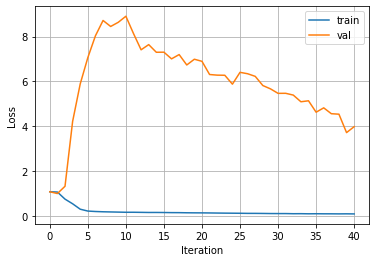

Iteration 42/500, Loss: 0.10875091701745987 - Val. loss: 3.816232919692993
Iteration 43/500, Loss: 0.11270686984062195 - Val. loss: 3.7992429733276367
Iteration 44/500, Loss: 0.10682535171508789 - Val. loss: 3.2384893894195557
Iteration 45/500, Loss: 0.11127837747335434 - Val. loss: 3.3690717220306396
Iteration 46/500, Loss: 0.10922831296920776 - Val. loss: 2.723439931869507
Iteration 47/500, Loss: 0.10955241322517395 - Val. loss: 2.943793296813965
Iteration 48/500, Loss: 0.10747158527374268 - Val. loss: 2.7322943210601807
Iteration 49/500, Loss: 0.10614155232906342 - Val. loss: 2.6192803382873535
Iteration 50/500, Loss: 0.10740572214126587 - Val. loss: 2.2811596393585205
Iteration 51/500, Loss: 0.10523267835378647 - Val. loss: 2.0911660194396973
Iteration 52/500, Loss: 0.10478608310222626 - Val. loss: 2.452890157699585
Iteration 53/500, Loss: 0.10510984063148499 - Val. loss: 1.6362463235855103
Iteration 54/500, Loss: 0.10207104682922363 - Val. loss: 1.7763363122940063
Iteration 55/500

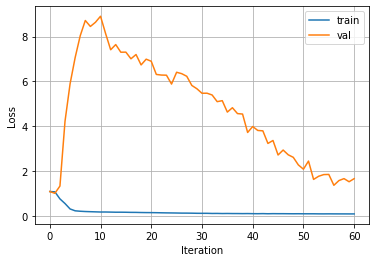

Iteration 62/500, Loss: 0.09983395785093307 - Val. loss: 1.252092957496643
Iteration 63/500, Loss: 0.0981067419052124 - Val. loss: 1.5467783212661743
Iteration 64/500, Loss: 0.0966838151216507 - Val. loss: 1.135369896888733
Iteration 65/500, Loss: 0.09889546036720276 - Val. loss: 1.3518723249435425
Iteration 66/500, Loss: 0.09430363029241562 - Val. loss: 1.2116440534591675
Iteration 67/500, Loss: 0.09498386830091476 - Val. loss: 1.1056678295135498
Iteration 68/500, Loss: 0.09699797630310059 - Val. loss: 1.4130946397781372
Iteration 69/500, Loss: 0.09655801951885223 - Val. loss: 1.6513519287109375
Iteration 70/500, Loss: 0.09722502529621124 - Val. loss: 1.3272885084152222
Iteration 71/500, Loss: 0.09547530859708786 - Val. loss: 1.7189195156097412
Iteration 72/500, Loss: 0.09375464916229248 - Val. loss: 1.3540453910827637
Iteration 73/500, Loss: 0.09741958975791931 - Val. loss: 1.3154246807098389
Iteration 74/500, Loss: 0.0957951545715332 - Val. loss: 1.1991064548492432
Iteration 75/500,

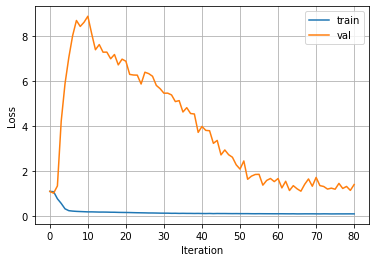

Iteration 82/500, Loss: 0.09575900435447693 - Val. loss: 1.2777907848358154
Iteration 83/500, Loss: 0.09476664662361145 - Val. loss: 1.5908572673797607
Iteration 84/500, Loss: 0.09189590811729431 - Val. loss: 1.0269138813018799
Iteration 85/500, Loss: 0.09279348701238632 - Val. loss: 1.186828374862671
Iteration 86/500, Loss: 0.0964527502655983 - Val. loss: 0.7737826704978943
Stored a new best model at iteration 86.
Iteration 87/500, Loss: 0.09440238773822784 - Val. loss: 1.2547303438186646
Iteration 88/500, Loss: 0.09235453605651855 - Val. loss: 1.098056674003601
Iteration 89/500, Loss: 0.09245758503675461 - Val. loss: 1.1151233911514282
Iteration 90/500, Loss: 0.0954296737909317 - Val. loss: 1.0758227109909058
Iteration 91/500, Loss: 0.09264607727527618 - Val. loss: 1.1048156023025513
Iteration 92/500, Loss: 0.09358986467123032 - Val. loss: 1.5025399923324585
Iteration 93/500, Loss: 0.0965954139828682 - Val. loss: 1.2109436988830566
Iteration 94/500, Loss: 0.09451083093881607 - Val. l

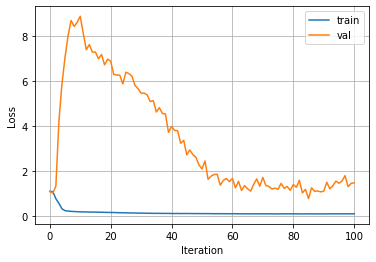

Iteration 102/500, Loss: 0.09732219576835632 - Val. loss: 1.4313207864761353
Iteration 103/500, Loss: 0.09781239926815033 - Val. loss: 1.1259620189666748
Iteration 104/500, Loss: 0.09949029237031937 - Val. loss: 1.0154019594192505
Iteration 105/500, Loss: 0.09492214769124985 - Val. loss: 1.283990740776062
Iteration 106/500, Loss: 0.09699990600347519 - Val. loss: 1.0603872537612915
Iteration 107/500, Loss: 0.10403518378734589 - Val. loss: 0.8699419498443604
Iteration 108/500, Loss: 0.10265546292066574 - Val. loss: 0.9989805817604065
Iteration 109/500, Loss: 0.1101725697517395 - Val. loss: 1.097522258758545
Iteration 110/500, Loss: 0.11220989376306534 - Val. loss: 0.7504780888557434
Stored a new best model at iteration 110.
Iteration 111/500, Loss: 0.10790401697158813 - Val. loss: 0.868076741695404
Iteration 112/500, Loss: 0.11522436141967773 - Val. loss: 0.9439857602119446
Iteration 113/500, Loss: 0.1262301802635193 - Val. loss: 0.8707707524299622
Iteration 114/500, Loss: 0.120573222637

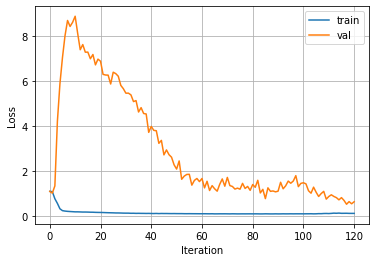

Iteration 122/500, Loss: 0.10791873931884766 - Val. loss: 0.6438162922859192
Iteration 123/500, Loss: 0.10701315850019455 - Val. loss: 0.6357980370521545
Iteration 124/500, Loss: 0.10754383355379105 - Val. loss: 0.6005975604057312
Iteration 125/500, Loss: 0.11013031005859375 - Val. loss: 0.4043233096599579
Stored a new best model at iteration 125.
Iteration 126/500, Loss: 0.10785907506942749 - Val. loss: 0.4497346878051758
Iteration 127/500, Loss: 0.1073511466383934 - Val. loss: 0.48530563712120056
Iteration 128/500, Loss: 0.10368802398443222 - Val. loss: 0.6415762901306152
Iteration 129/500, Loss: 0.10243038833141327 - Val. loss: 0.4819784462451935
Iteration 130/500, Loss: 0.10339359194040298 - Val. loss: 0.49951186776161194
Iteration 131/500, Loss: 0.10330897569656372 - Val. loss: 0.6191635131835938
Iteration 132/500, Loss: 0.10482529550790787 - Val. loss: 0.40524476766586304
Iteration 133/500, Loss: 0.10483429580926895 - Val. loss: 0.45079028606414795
Iteration 134/500, Loss: 0.1005

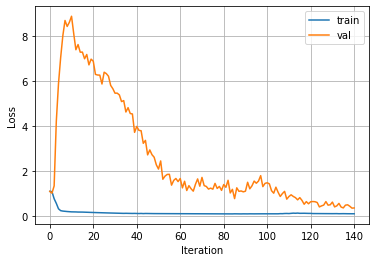

Iteration 142/500, Loss: 0.10070418566465378 - Val. loss: 0.3441218435764313
Stored a new best model at iteration 142.
Iteration 143/500, Loss: 0.09911953657865524 - Val. loss: 0.43181684613227844
Iteration 144/500, Loss: 0.09974312782287598 - Val. loss: 0.3415758013725281
Stored a new best model at iteration 144.
Iteration 145/500, Loss: 0.10143804550170898 - Val. loss: 0.3058850169181824
Stored a new best model at iteration 145.
Iteration 146/500, Loss: 0.10596638172864914 - Val. loss: 0.37729763984680176
Iteration 147/500, Loss: 0.10192516446113586 - Val. loss: 0.3003526031970978
Stored a new best model at iteration 147.
Iteration 148/500, Loss: 0.09989672154188156 - Val. loss: 0.31974828243255615
Iteration 149/500, Loss: 0.10484117269515991 - Val. loss: 0.33204200863838196
Iteration 150/500, Loss: 0.10130613297224045 - Val. loss: 0.3295104503631592
Iteration 151/500, Loss: 0.10021627694368362 - Val. loss: 0.3424607813358307
Iteration 152/500, Loss: 0.10135021805763245 - Val. loss: 

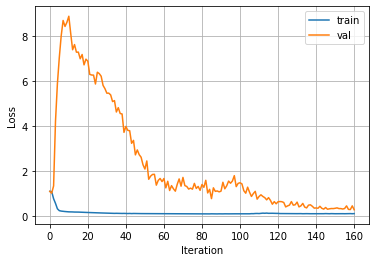

Iteration 162/500, Loss: 0.10193540900945663 - Val. loss: 0.30646395683288574
Iteration 163/500, Loss: 0.10434387624263763 - Val. loss: 0.3102267384529114
Iteration 164/500, Loss: 0.10525741428136826 - Val. loss: 0.4387754201889038
Iteration 165/500, Loss: 0.1055237278342247 - Val. loss: 0.3191467523574829
Iteration 166/500, Loss: 0.10813896358013153 - Val. loss: 0.33791324496269226
Iteration 167/500, Loss: 0.10735830664634705 - Val. loss: 0.34214675426483154
Iteration 168/500, Loss: 0.10326967388391495 - Val. loss: 0.3117069602012634
Iteration 169/500, Loss: 0.10616152733564377 - Val. loss: 0.32827049493789673
Iteration 170/500, Loss: 0.10873796790838242 - Val. loss: 0.3060319125652313
Iteration 171/500, Loss: 0.10745274275541306 - Val. loss: 0.3130660653114319
Iteration 172/500, Loss: 0.10653605312108994 - Val. loss: 0.34500619769096375
Iteration 173/500, Loss: 0.11033036559820175 - Val. loss: 0.31046777963638306
Iteration 174/500, Loss: 0.10989506542682648 - Val. loss: 0.26448944211

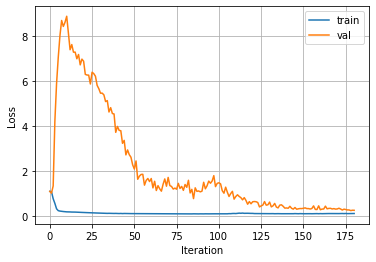

Iteration 182/500, Loss: 0.10931612551212311 - Val. loss: 0.24832357466220856
Iteration 183/500, Loss: 0.11086152493953705 - Val. loss: 0.2953788936138153
Iteration 184/500, Loss: 0.11252269148826599 - Val. loss: 0.2423778623342514
Iteration 185/500, Loss: 0.11252254992723465 - Val. loss: 0.22949452698230743
Stored a new best model at iteration 185.
Iteration 186/500, Loss: 0.11293761432170868 - Val. loss: 0.2234269678592682
Stored a new best model at iteration 186.
Iteration 187/500, Loss: 0.11369871348142624 - Val. loss: 0.21795932948589325
Stored a new best model at iteration 187.
Iteration 188/500, Loss: 0.11239557713270187 - Val. loss: 0.23141445219516754
Iteration 189/500, Loss: 0.11521454155445099 - Val. loss: 0.22309482097625732
Iteration 190/500, Loss: 0.11357977241277695 - Val. loss: 0.24016223847866058
Iteration 191/500, Loss: 0.1121983528137207 - Val. loss: 0.22144579887390137
Iteration 192/500, Loss: 0.11524660140275955 - Val. loss: 0.2077990025281906
Stored a new best mod

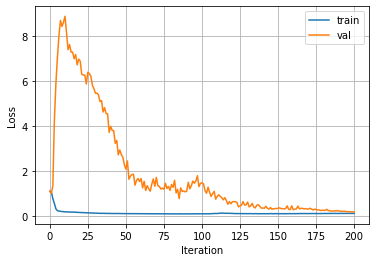

Iteration 202/500, Loss: 0.11511998623609543 - Val. loss: 0.15808171033859253
Stored a new best model at iteration 202.
Iteration 203/500, Loss: 0.11306609213352203 - Val. loss: 0.16474132239818573
Iteration 204/500, Loss: 0.11176013201475143 - Val. loss: 0.16281846165657043
Iteration 205/500, Loss: 0.11529045552015305 - Val. loss: 0.15781505405902863
Stored a new best model at iteration 205.
Iteration 206/500, Loss: 0.11943457275629044 - Val. loss: 0.14562655985355377
Stored a new best model at iteration 206.
Iteration 207/500, Loss: 0.11035353690385818 - Val. loss: 0.14832523465156555
Iteration 208/500, Loss: 0.11038485169410706 - Val. loss: 0.15177515149116516
Iteration 209/500, Loss: 0.1122819110751152 - Val. loss: 0.1410205364227295
Stored a new best model at iteration 209.
Iteration 210/500, Loss: 0.10812471061944962 - Val. loss: 0.14406979084014893
Iteration 211/500, Loss: 0.11066140234470367 - Val. loss: 0.1419707089662552
Iteration 212/500, Loss: 0.11039543896913528 - Val. los

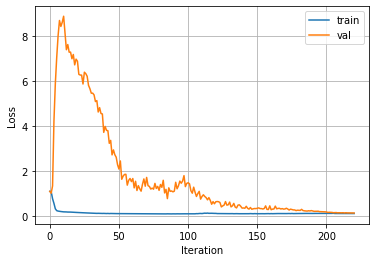

Iteration 222/500, Loss: 0.1091119721531868 - Val. loss: 0.13095179200172424
Stored a new best model at iteration 222.
Iteration 223/500, Loss: 0.10956931859254837 - Val. loss: 0.13054054975509644
Stored a new best model at iteration 223.
Iteration 224/500, Loss: 0.11013229191303253 - Val. loss: 0.1370057612657547
Iteration 225/500, Loss: 0.11066222935914993 - Val. loss: 0.1285572201013565
Stored a new best model at iteration 225.
Iteration 226/500, Loss: 0.1079757884144783 - Val. loss: 0.12913250923156738
Iteration 227/500, Loss: 0.11032935231924057 - Val. loss: 0.1298854947090149
Iteration 228/500, Loss: 0.11130309849977493 - Val. loss: 0.12795616686344147
Stored a new best model at iteration 228.
Iteration 229/500, Loss: 0.10705002397298813 - Val. loss: 0.12921592593193054
Iteration 230/500, Loss: 0.10796236991882324 - Val. loss: 0.12876681983470917
Iteration 231/500, Loss: 0.10857372730970383 - Val. loss: 0.12533940374851227
Stored a new best model at iteration 231.
Iteration 232/5

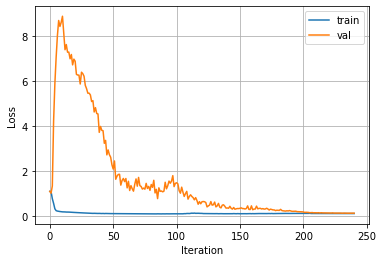

Iteration 242/500, Loss: 0.10991048812866211 - Val. loss: 0.1257309764623642
Iteration 243/500, Loss: 0.10874705016613007 - Val. loss: 0.12524648010730743
Iteration 244/500, Loss: 0.10910798609256744 - Val. loss: 0.12290801107883453
Stored a new best model at iteration 244.
Iteration 245/500, Loss: 0.10942637920379639 - Val. loss: 0.12340769916772842
Iteration 246/500, Loss: 0.11037182062864304 - Val. loss: 0.12214688956737518
Stored a new best model at iteration 246.
Iteration 247/500, Loss: 0.10921422392129898 - Val. loss: 0.1243286281824112
Iteration 248/500, Loss: 0.10900231450796127 - Val. loss: 0.12218631058931351
Iteration 249/500, Loss: 0.10702542960643768 - Val. loss: 0.1231234222650528
Iteration 250/500, Loss: 0.10769600421190262 - Val. loss: 0.1216459795832634
Stored a new best model at iteration 250.
Iteration 251/500, Loss: 0.10829239338636398 - Val. loss: 0.12132839113473892
Stored a new best model at iteration 251.
Iteration 252/500, Loss: 0.10842009633779526 - Val. loss

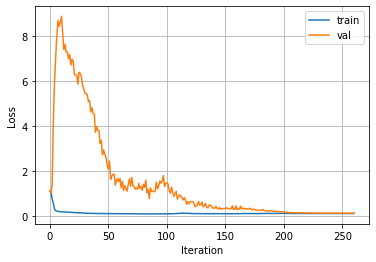

Iteration 262/500, Loss: 0.11354562640190125 - Val. loss: 0.12014922499656677
Stored a new best model at iteration 262.
Iteration 263/500, Loss: 0.11205963045358658 - Val. loss: 0.11961255967617035
Stored a new best model at iteration 263.
Iteration 264/500, Loss: 0.1122804805636406 - Val. loss: 0.12298627942800522
Iteration 265/500, Loss: 0.11068398505449295 - Val. loss: 0.11945553869009018
Stored a new best model at iteration 265.
Iteration 266/500, Loss: 0.11189962923526764 - Val. loss: 0.11878231167793274
Stored a new best model at iteration 266.
Iteration 267/500, Loss: 0.1104787290096283 - Val. loss: 0.11989210546016693
Iteration 268/500, Loss: 0.11165407299995422 - Val. loss: 0.12284673750400543
Iteration 269/500, Loss: 0.11226655542850494 - Val. loss: 0.1209072694182396
Iteration 270/500, Loss: 0.10934773832559586 - Val. loss: 0.11938868463039398
Iteration 271/500, Loss: 0.10904859006404877 - Val. loss: 0.11948906630277634
Iteration 272/500, Loss: 0.1075909286737442 - Val. loss

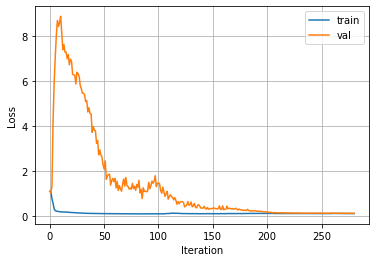

Iteration 282/500, Loss: 0.10640306770801544 - Val. loss: 0.12230760604143143
Iteration 283/500, Loss: 0.1049058809876442 - Val. loss: 0.12003913521766663
Iteration 284/500, Loss: 0.1042281985282898 - Val. loss: 0.11965595930814743
Iteration 285/500, Loss: 0.10803625732660294 - Val. loss: 0.12011208385229111
Iteration 286/500, Loss: 0.11178456991910934 - Val. loss: 0.11986349523067474
Iteration 287/500, Loss: 0.11150920391082764 - Val. loss: 0.11806640028953552
Stored a new best model at iteration 287.
Iteration 288/500, Loss: 0.11030096560716629 - Val. loss: 0.11709737032651901
Stored a new best model at iteration 288.
Iteration 289/500, Loss: 0.10933813452720642 - Val. loss: 0.11867372691631317
Iteration 290/500, Loss: 0.10710953176021576 - Val. loss: 0.11958908289670944
Epoch   290: reducing learning rate of group 0 to 1.0000e-05.
Iteration 291/500, Loss: 0.1064004972577095 - Val. loss: 0.11882133036851883
Iteration 292/500, Loss: 0.10575713962316513 - Val. loss: 0.11813746392726898

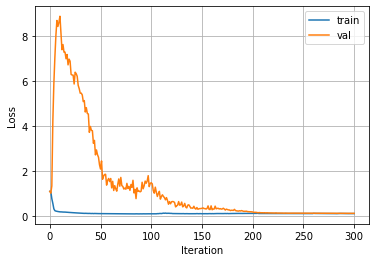

Iteration 302/500, Loss: 0.10573556274175644 - Val. loss: 0.11767477542161942
Iteration 303/500, Loss: 0.106971874833107 - Val. loss: 0.11732496321201324
Iteration 304/500, Loss: 0.10636477172374725 - Val. loss: 0.11728303879499435
Iteration 305/500, Loss: 0.10641126334667206 - Val. loss: 0.1176089271903038
Iteration 306/500, Loss: 0.10617570579051971 - Val. loss: 0.11735138297080994
Iteration 307/500, Loss: 0.10564571619033813 - Val. loss: 0.1169135645031929
Stored a new best model at iteration 307.
Iteration 308/500, Loss: 0.10569353401660919 - Val. loss: 0.11728274822235107
Iteration 309/500, Loss: 0.10524778068065643 - Val. loss: 0.11657226085662842
Stored a new best model at iteration 309.
Iteration 310/500, Loss: 0.10502298176288605 - Val. loss: 0.11645225435495377
Stored a new best model at iteration 310.
Iteration 311/500, Loss: 0.10534950345754623 - Val. loss: 0.1161288395524025
Stored a new best model at iteration 311.
Iteration 312/500, Loss: 0.10520102828741074 - Val. loss:

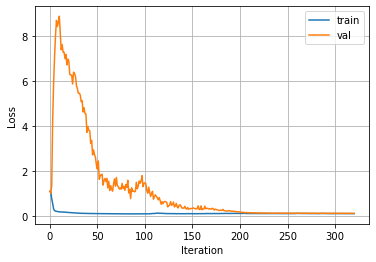

Iteration 322/500, Loss: 0.10623504221439362 - Val. loss: 0.11671792715787888
Iteration 323/500, Loss: 0.10468455404043198 - Val. loss: 0.1166003867983818
Iteration 324/500, Loss: 0.10597935318946838 - Val. loss: 0.11668369174003601
Iteration 325/500, Loss: 0.1049187108874321 - Val. loss: 0.11637241393327713
Iteration 326/500, Loss: 0.10654805600643158 - Val. loss: 0.1163892075419426
Iteration 327/500, Loss: 0.10493653267621994 - Val. loss: 0.11645733565092087
Iteration 328/500, Loss: 0.1061268150806427 - Val. loss: 0.11639577895402908
Iteration 329/500, Loss: 0.10637781023979187 - Val. loss: 0.11670040339231491
Iteration 330/500, Loss: 0.10592855513095856 - Val. loss: 0.1168973296880722
Iteration 331/500, Loss: 0.10571490973234177 - Val. loss: 0.11685594171285629
Iteration 332/500, Loss: 0.10517030954360962 - Val. loss: 0.11661708354949951
Iteration 333/500, Loss: 0.10670866817235947 - Val. loss: 0.11663893610239029
Iteration 334/500, Loss: 0.10438716411590576 - Val. loss: 0.116674222

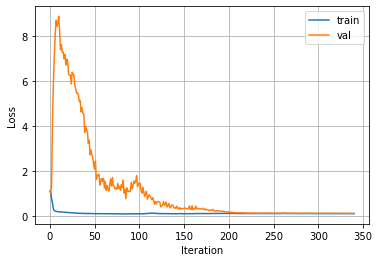

Iteration 342/500, Loss: 0.10526498407125473 - Val. loss: 0.11659874767065048
Iteration 343/500, Loss: 0.10628847777843475 - Val. loss: 0.11657921969890594
Iteration 344/500, Loss: 0.10512018203735352 - Val. loss: 0.1165730357170105
Iteration 345/500, Loss: 0.10543728619813919 - Val. loss: 0.11671208590269089
Iteration 346/500, Loss: 0.10444957762956619 - Val. loss: 0.11651694774627686
Iteration 347/500, Loss: 0.10608845204114914 - Val. loss: 0.11651071161031723
Iteration 348/500, Loss: 0.1062600389122963 - Val. loss: 0.11654867231845856
Iteration 349/500, Loss: 0.10485336929559708 - Val. loss: 0.11654940992593765
Iteration 350/500, Loss: 0.10450532287359238 - Val. loss: 0.1165003553032875
Iteration 351/500, Loss: 0.10629938542842865 - Val. loss: 0.11649292707443237
Iteration 352/500, Loss: 0.10422637313604355 - Val. loss: 0.11650257557630539
Iteration 353/500, Loss: 0.10600856691598892 - Val. loss: 0.11650235950946808
Iteration 354/500, Loss: 0.10683812201023102 - Val. loss: 0.1165065

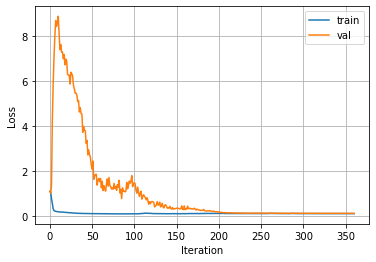

Iteration 362/500, Loss: 0.10575433075428009 - Val. loss: 0.11659332364797592
Iteration 363/500, Loss: 0.10486350953578949 - Val. loss: 0.1165764257311821
Iteration 364/500, Loss: 0.10601256042718887 - Val. loss: 0.11653376370668411
Iteration 365/500, Loss: 0.1057627722620964 - Val. loss: 0.11644524335861206
Iteration 366/500, Loss: 0.10563503205776215 - Val. loss: 0.11642412096261978
Iteration 367/500, Loss: 0.10627343505620956 - Val. loss: 0.11654050648212433
Iteration 368/500, Loss: 0.10498879849910736 - Val. loss: 0.11657251417636871
Iteration 369/500, Loss: 0.10521047562360764 - Val. loss: 0.11656809598207474
Iteration 370/500, Loss: 0.10389616340398788 - Val. loss: 0.11653890460729599
Iteration 371/500, Loss: 0.10592911392450333 - Val. loss: 0.11657927185297012
Iteration 372/500, Loss: 0.10579601675271988 - Val. loss: 0.11645795404911041
Iteration 373/500, Loss: 0.10493920743465424 - Val. loss: 0.11651909351348877
Iteration 374/500, Loss: 0.10493213683366776 - Val. loss: 0.116572

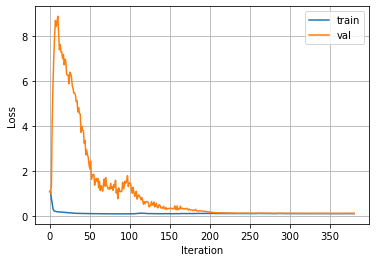

Iteration 382/500, Loss: 0.10463175922632217 - Val. loss: 0.11664231866598129
Iteration 383/500, Loss: 0.10506454110145569 - Val. loss: 0.11664659529924393
Iteration 384/500, Loss: 0.10534542053937912 - Val. loss: 0.11667099595069885
Iteration 385/500, Loss: 0.10530289262533188 - Val. loss: 0.11664743721485138
Iteration 386/500, Loss: 0.10583177953958511 - Val. loss: 0.11667594313621521
Iteration 387/500, Loss: 0.10450220108032227 - Val. loss: 0.11663655936717987
Iteration 388/500, Loss: 0.10639750212430954 - Val. loss: 0.11661951243877411
Iteration 389/500, Loss: 0.10531629621982574 - Val. loss: 0.116642065346241
Iteration 390/500, Loss: 0.1054689958691597 - Val. loss: 0.11665525287389755
Iteration 391/500, Loss: 0.10526125878095627 - Val. loss: 0.11665157228708267
Iteration 392/500, Loss: 0.10414285957813263 - Val. loss: 0.11639119684696198
Iteration 393/500, Loss: 0.10526351630687714 - Val. loss: 0.11641020327806473
Iteration 394/500, Loss: 0.10412930697202682 - Val. loss: 0.1163515

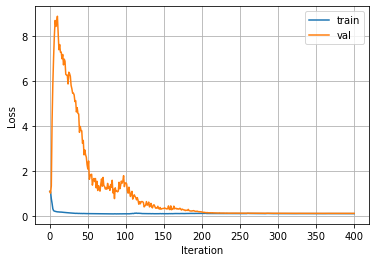

Iteration 402/500, Loss: 0.10445055365562439 - Val. loss: 0.1164827048778534
Iteration 403/500, Loss: 0.10543637722730637 - Val. loss: 0.11654641479253769
Iteration 404/500, Loss: 0.1057419702410698 - Val. loss: 0.11652582138776779
Iteration 405/500, Loss: 0.10424789786338806 - Val. loss: 0.11652415990829468
Iteration 406/500, Loss: 0.10367277264595032 - Val. loss: 0.11665081977844238
Iteration 407/500, Loss: 0.10594284534454346 - Val. loss: 0.11661181598901749
Iteration 408/500, Loss: 0.10511798411607742 - Val. loss: 0.11647938936948776
Iteration 409/500, Loss: 0.10372279584407806 - Val. loss: 0.11648803949356079
Iteration 410/500, Loss: 0.10380849242210388 - Val. loss: 0.11655193567276001
Iteration 411/500, Loss: 0.10312484949827194 - Val. loss: 0.11646914482116699
Iteration 412/500, Loss: 0.10467509925365448 - Val. loss: 0.11651311814785004
Iteration 413/500, Loss: 0.10475393384695053 - Val. loss: 0.11653053760528564
Iteration 414/500, Loss: 0.10514038801193237 - Val. loss: 0.116523

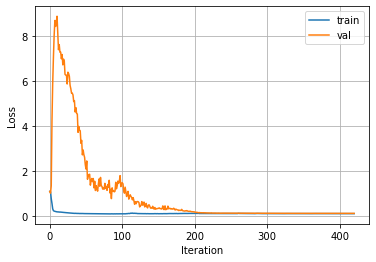

Iteration 422/500, Loss: 0.10507276654243469 - Val. loss: 0.11642931401729584
Iteration 423/500, Loss: 0.10487546771764755 - Val. loss: 0.11644331365823746
Iteration 424/500, Loss: 0.10624787211418152 - Val. loss: 0.11654343456029892
Iteration 425/500, Loss: 0.10619909316301346 - Val. loss: 0.11651807278394699
Iteration 426/500, Loss: 0.10451822727918625 - Val. loss: 0.11654003709554672
Iteration 427/500, Loss: 0.10378456115722656 - Val. loss: 0.1165408119559288
Iteration 428/500, Loss: 0.10567311942577362 - Val. loss: 0.1166079193353653
Iteration 429/500, Loss: 0.10372722893953323 - Val. loss: 0.11641836911439896
Iteration 430/500, Loss: 0.10350964963436127 - Val. loss: 0.11644435673952103
Iteration 431/500, Loss: 0.10472144931554794 - Val. loss: 0.11657445877790451
Iteration 432/500, Loss: 0.1037902906537056 - Val. loss: 0.11656536906957626
Iteration 433/500, Loss: 0.10538358986377716 - Val. loss: 0.11661908030509949
Iteration 434/500, Loss: 0.10339733213186264 - Val. loss: 0.1164235

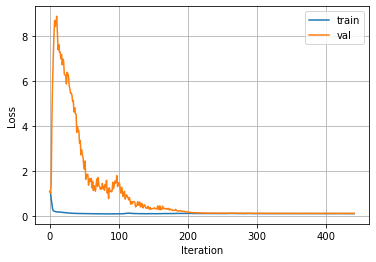

Iteration 442/500, Loss: 0.10438274592161179 - Val. loss: 0.11648444086313248
Iteration 443/500, Loss: 0.10600370913743973 - Val. loss: 0.11649782955646515
Iteration 444/500, Loss: 0.10391964763402939 - Val. loss: 0.11650610715150833
Iteration 445/500, Loss: 0.1038566380739212 - Val. loss: 0.11648143082857132
Iteration 446/500, Loss: 0.10472384840250015 - Val. loss: 0.11643863469362259
Iteration 447/500, Loss: 0.10537732392549515 - Val. loss: 0.1164921224117279
Iteration 448/500, Loss: 0.10622631758451462 - Val. loss: 0.11644485592842102
Iteration 449/500, Loss: 0.105861134827137 - Val. loss: 0.11649730801582336
Iteration 450/500, Loss: 0.10622971504926682 - Val. loss: 0.1164717748761177
Iteration 451/500, Loss: 0.1044371947646141 - Val. loss: 0.11648570001125336
Iteration 452/500, Loss: 0.10545103996992111 - Val. loss: 0.11642434448003769
Iteration 453/500, Loss: 0.10447882115840912 - Val. loss: 0.11644644290208817
Iteration 454/500, Loss: 0.10467632114887238 - Val. loss: 0.1164914518

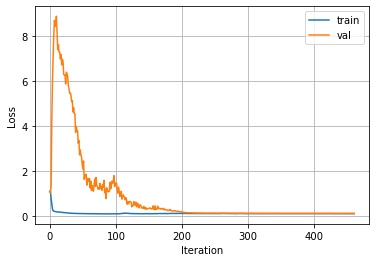

Iteration 462/500, Loss: 0.10611383616924286 - Val. loss: 0.11648774147033691
Iteration 463/500, Loss: 0.10557249188423157 - Val. loss: 0.11650785058736801
Iteration 464/500, Loss: 0.10433152318000793 - Val. loss: 0.11647672951221466
Iteration 465/500, Loss: 0.10506269335746765 - Val. loss: 0.11648154258728027
Iteration 466/500, Loss: 0.10520815849304199 - Val. loss: 0.11647318303585052
Iteration 467/500, Loss: 0.10383200645446777 - Val. loss: 0.11655110120773315
Iteration 468/500, Loss: 0.10521601140499115 - Val. loss: 0.11648847162723541
Iteration 469/500, Loss: 0.10487682372331619 - Val. loss: 0.1164819523692131
Iteration 470/500, Loss: 0.1037522703409195 - Val. loss: 0.11648249626159668
Iteration 471/500, Loss: 0.10482245683670044 - Val. loss: 0.11649361252784729
Iteration 472/500, Loss: 0.104866623878479 - Val. loss: 0.11646293848752975
Iteration 473/500, Loss: 0.10522302240133286 - Val. loss: 0.11648010462522507
Iteration 474/500, Loss: 0.10400823503732681 - Val. loss: 0.11649920

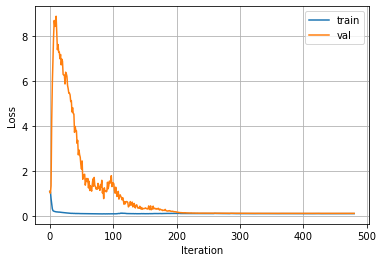

Iteration 482/500, Loss: 0.10585391521453857 - Val. loss: 0.11627592146396637
Iteration 483/500, Loss: 0.10677190124988556 - Val. loss: 0.11656349152326584
Iteration 484/500, Loss: 0.10521858185529709 - Val. loss: 0.11650525033473969
Iteration 485/500, Loss: 0.10527332127094269 - Val. loss: 0.11655186861753464
Iteration 486/500, Loss: 0.105702705681324 - Val. loss: 0.11659220606088638
Iteration 487/500, Loss: 0.1043090894818306 - Val. loss: 0.1165931448340416
Iteration 488/500, Loss: 0.1041756272315979 - Val. loss: 0.11659647524356842
Iteration 489/500, Loss: 0.1043972373008728 - Val. loss: 0.11654859036207199
Iteration 490/500, Loss: 0.10422217100858688 - Val. loss: 0.11661089211702347
Iteration 491/500, Loss: 0.10491607338190079 - Val. loss: 0.11654584109783173
Iteration 492/500, Loss: 0.10535036027431488 - Val. loss: 0.11643948405981064
Iteration 493/500, Loss: 0.10477858781814575 - Val. loss: 0.11660844832658768
Iteration 494/500, Loss: 0.10427224636077881 - Val. loss: 0.1165046542

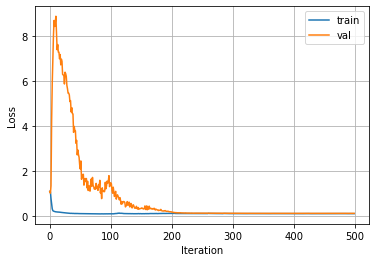

In [6]:
# Define the model
model = Model(hypernet_settings=settings['hypernet_settings'],
                encoder_settings=settings['encoder_settings'],
                sampling_type=settings['sampling_type'],
                nr_classes=settings['nr_classes'])

model.to(device)

# Define optimizer and lr scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, verbose=True, min_lr=1e-6)

# Create dataloaders for the train and validation sets
data_loaders = []
for data_fold in ['train', 'val']:
    data_set = synthetic_dataset(data_fold=data_fold, channels=['ch0','ch1'], nr_classes=nr_classes)
    data_loaders.append(DataLoader(data_set,
                                    batch_size=128,
                                    shuffle= True if data_fold == 'train' else False,
                                    drop_last=False,
                                    pin_memory=True,
                                    num_workers= 0))
data_loader_train, data_loader_val = data_loaders

# Training loop
all_losses = {'train':[], 'val':[]}
best_val_loss = np.inf

for i in range(nr_iters):
    total_loss_train = []
    model.train()
    for x_train, y_train in data_loader_train:
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # Zero the gradients
        model.zero_grad()

        # Forward pass
        y_hat_train,_ = model(x_train, i)
        loss =  F.nll_loss(y_hat_train, y_train)
        total_loss_train.append(loss.clone().to('cpu').detach().numpy())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    total_loss_val = []
    with torch.no_grad():
        for x_val, y_val in data_loader_val:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_hat_val,_ = model(x_val, i)
            loss_val =  F.nll_loss(y_hat_val, y_val)
            total_loss_val.append(loss_val.clone().to('cpu').detach().numpy())
    
    if i > (nr_iters//2-1):     
        scheduler.step(metrics=loss_val, epoch=i) 

    all_losses['train'].append(np.mean(total_loss_train))
    all_losses['val'].append(np.mean(total_loss_val))
    print(f"Iteration {i+1}/{nr_iters}, Loss: {all_losses['train'][-1]} - Val. loss: {all_losses['val'][-1]}")

    if all_losses['val'][-1] < best_val_loss:
        best_val_loss = all_losses['val'][-1]
        torch.save(model.state_dict(), 'best_model.pt')
        print(f'Stored a new best model at iteration {i+1}.' )

    if (i > 0 and i % 20 == 0) or (i == nr_iters-1):    
        # The validation loss first increases, while the train loss decreases due to 
        # the fact that during training soft samples are used, which are annealed to hard samples via the GS temperature parameter.
        plt.plot(all_losses['train'], label='train')
        plt.plot(all_losses['val'], label='val')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


### Evaluate the model

As can be seen in the training graphs, the validation loss first increases, while the training loss already decreases. 
This is caused by the fact that we use soft-sampling during training, while already evaluating the validation set using hard samples.
Towards the end of training, both losses converge to a similar value, as we anneal the Gumbel-Softmax temperature to a lower value.

Let's evaluate the F1 scores for classification (as provided in Table 1 of the paper).

In [7]:
from sklearn.metrics import f1_score

# Load the best model
model = Model(hypernet_settings=settings['hypernet_settings'],
                encoder_settings=settings['encoder_settings'],
                sampling_type=settings['sampling_type'],
                nr_classes=settings['nr_classes'])

model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()

# Evaluate the model on the test dataset
data_set_test = synthetic_dataset(data_fold='test', channels=['ch0','ch1'], nr_classes=nr_classes)
data_loader_test = DataLoader(data_set_test,
                    batch_size=128,
                    shuffle= False,
                    drop_last=False,
                    pin_memory=True,
                    num_workers= 0)


total_loss_test = []
all_y_test, all_y_hat_test = [], []
with torch.no_grad():
    for x_test, y_test in data_loader_test:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        y_hat_test, _ = model(x_test)
        loss_test = F.nll_loss(y_hat_test, y_test)
        total_loss_test.append(loss_test.clone().to('cpu').detach().numpy())

        all_y_test.extend(y_test.clone().to('cpu').detach().numpy())
        all_y_hat_test.extend(y_hat_test.clone().to('cpu').detach().numpy())

print(f"Test loss: {np.mean(total_loss_test):.2f}")

f1_scores = np.array(f1_score(all_y_test, np.stack(all_y_hat_test,0).argmax(1), average=None, labels=[0,1,2]))*100
print(f'F1 scores per class: {f1_scores}')
print(f'Avg. F1 score: {np.mean(f1_scores):.2f}')


Test loss: 0.12
F1 scores per class: [93.79188713 94.40313112 95.23545706]
Avg. F1 score: 94.48


### Plot part of a test subject's data and the selected mini-windows in green

In [9]:
subject = 's150' # the test set contains subjects between s150 and s199

xtest, ytest = data_set_test.get_subject(subject)
xtest = torch.as_tensor(xtest, device=device)
ytest = torch.as_tensor(ytest, device=device)

with torch.no_grad():    
    x_test_chunked = torch.stack(torch.chunk(xtest, xtest.shape[-1] // window_length, dim=1),0) #[nr windows, channels, window_length]
    y_hat_subject, selection_matrix = model(x_test_chunked) #[nr windows, nr_classes], [nr windows, k, nr mini windows in a window]

y_hat_subject = y_hat_subject.clone().to('cpu').detach().numpy()
selection_matrix = selection_matrix.clone().to('cpu').detach().numpy()

# Convert the selection matrix of size [nr windows , k , N] to a binary sampling mask of shape [nr windows, nr channels, nr mini-windows per window]
selection_mask = selection_matrix.reshape((-1,k,nr_channels,settings['hypernet_settings']['mini_window_temporal_reduction_factor'])).sum(1)


Text(0.5, 1.3, 'Selected mini-windows in green\nSubject: s150 @0sec')

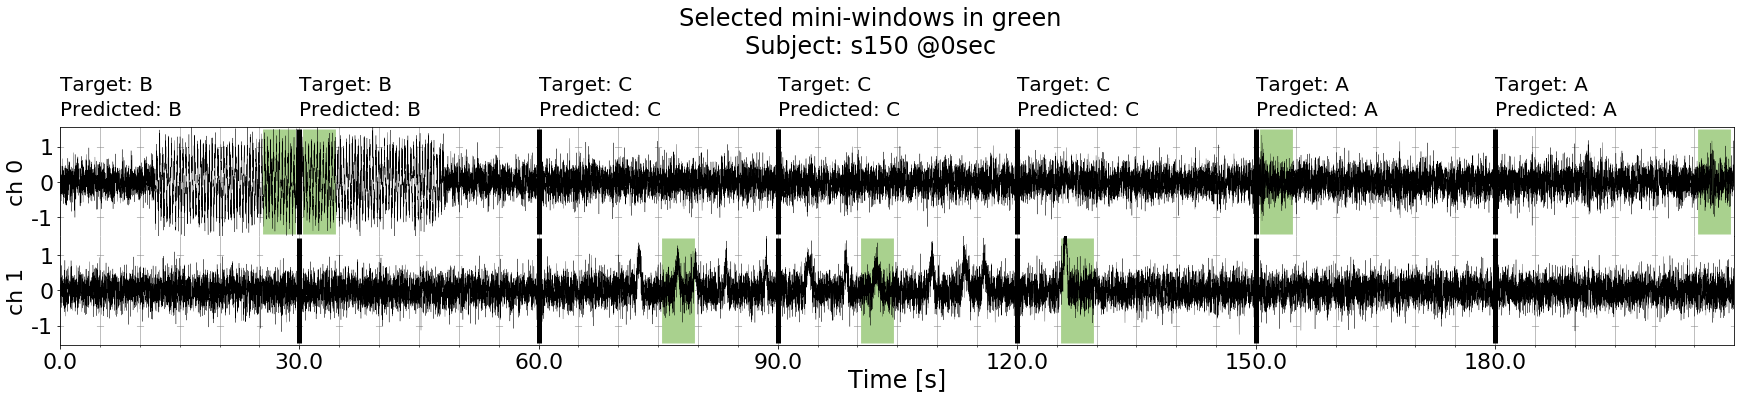

In [10]:
from matplotlib.colors import ListedColormap

### Indicate which window indices to plot
window_idx_start, window_idx_end = 0, 7
###

fs = data_set_test.fs #sampling frequency
raw_data = x_test_chunked.clone().to('cpu').detach().numpy()

start_sec, end_sec = window_idx_start*30, window_idx_end*30
start_sample, end_sample = start_sec*fs, end_sec*fs
time_axis = np.arange(start_sample, end_sample)


fig, axs = plt.subplots(2, 1, figsize=(30,4), sharex=True)
plt.subplots_adjust(hspace=0.)


ch_list = ['ch0', 'ch1']
ymin, ymax = -1, 1
for ch_idx, ch in enumerate(ch_list):

    # Plot the feature masks for both channels in the same plots where the data is also plotted, and indicate the selected mini-windows in green
    # white-green cmap for selected windows
    color0 = '#FFFFFF'  # White
    color1 = '#A9D18E'  # Green
    cmap_windows = ListedColormap([color0, color1])
    im = axs[ch_idx].vlines(np.arange(start_sample+2.5*fs,end_sample+2.5*fs,5*fs), ymin=-1.5, ymax=1.5, colors=cmap_windows(selection_mask[window_idx_start:window_idx_end,ch_idx].flatten()), linewidth=6900/(end_sec-start_sec), alpha=1)

    # Plot the data streams on top
    axs[ch_idx].plot(time_axis, raw_data[window_idx_start:window_idx_end,ch_idx].flatten(), 'k', linewidth=0.3) 
    axs[ch_idx].set_xticks(np.arange(start_sample, end_sample, 5*fs), minor=True) # minor ticks at 5s mini-windows
    axs[ch_idx].set_xticks(np.arange(start_sample, end_sample, 30*fs))
    axs[ch_idx].set_xticklabels(np.arange(0, end_sample-start_sample, 30*fs)/fs, fontsize=22)
    
    ymin, ymax = -1.5,1.5
    axs[ch_idx].set_ylim([ymin-0.05, ymax+0.05])
    axs[ch_idx].set_yticks([-1, 0, 1])
    axs[ch_idx].set_yticklabels(labels=[-1, 0, 1],fontsize=22)
        
    # Set grid lines
    axs[ch_idx].grid(True, which='both', linestyle='-', linewidth='0.5', color='gray', axis='x')
    axs[ch_idx].grid(True, which='major', linestyle='-', linewidth='0.5', color='gray', axis='y')

    # Plot a line at 30-second window boundaries
    axs[ch_idx].vlines(np.arange(start_sample+3000, end_sample, 30*fs), ymin=ymin, ymax=ymax, colors='k', linewidth=5, zorder=10)
    axs[ch_idx].set_ylabel(f'ch {ch_idx}',fontsize=22)
    axs[ch_idx].margins(x=0)


axs[ch_idx].set_xlabel('Time [s]',fontsize=24, labelpad=-5)

conv_label = {0:'A', 1:'B', 2:'C'}
preds = np.argmax(y_hat_subject,-1)[window_idx_start:window_idx_end]
targets = ytest[window_idx_start:window_idx_end].clone().to('cpu').detach().numpy()
for i, (y_hat, y) in enumerate(zip(preds, targets)):
    plt.text(time_axis[i*3000],5.7, f'Target: {conv_label[y]}', fontsize=20)
    plt.text(time_axis[i*3000],5.0, f'Predicted: {conv_label[y_hat]}',fontsize=20)

axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.suptitle(f'Selected mini-windows in green\nSubject: {subject} @{start_sec}sec', y=1.3, fontsize=24)